<a href="https://colab.research.google.com/github/MengOonLee/Deep_learning/blob/master/PyTorch/Experiments/Transformer/TimeSeries/T01_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Time Series

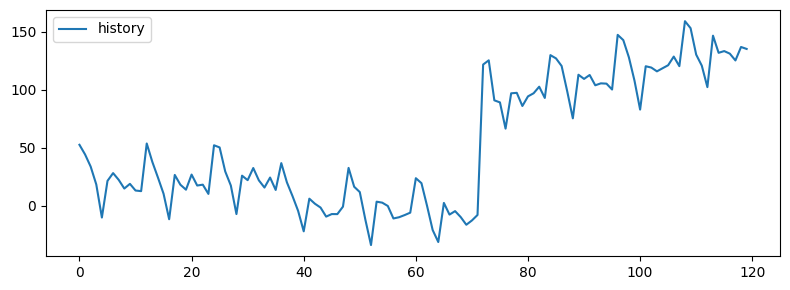

In [1]:
import numpy as np
np.random.seed(seed=42)
import matplotlib.pyplot as plt
import seaborn as sns

def trend(time):
    slope = np.zeros_like(a=time)
    slope[time < (3*12)] = 0.2
    slope[(time >= (3*12)) & (time < (6*12))] = -0.4
    slope[time >= (6*12)] = 1.0
    return slope * time

def seasonal_pattern(season_time):
    return np.where(season_time < 0.4, np.cos(season_time * 2 * np.pi),
        1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=5):
    rnd = np.random.RandomState(seed=42)
    return rnd.randn(len(time)) * noise_level

period = 12; baseline = 10; amplitude = 40

time_history = np.arange(10*12, dtype=np.float32)
ts_history = baseline + trend(time=time_history)\
    + seasonality(time=time_history, period=period, amplitude=amplitude)\
    + noise(time=time_history)
ts_history = ts_history.astype(np.float32)

plt.figure(figsize=(8, 3))
sns.lineplot(x=time_history, y=ts_history, label='history')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

### Dataset & DataLoader

In [2]:
from sklearn import preprocessing
import torch

src_len = 24; tgt_len = 12
ts_train = ts_history[:-12]; ts_test = ts_history[-(src_len+12):]
scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1))
scaler.fit(X=ts_train.reshape(-1, 1))

class TrainingDataset(torch.utils.data.Dataset):
    def __init__(self, ts, src_len, tgt_len):
        super().__init__()
        self.ts = torch.tensor(data=ts, dtype=torch.float32).view(-1, 1)
        self.src_len = src_len; self.tgt_len = tgt_len
        self.idxs = list(range(len(ts) - (src_len + tgt_len) + 1))

    def __len__(self):
        return len(self.idxs)

    def __getitem__(self, idx):
        data = {}
        i = self.idxs[idx]

        start = i; end = i + self.src_len
        data['src'] = self.ts[start : end]
        data['src_idx'] = torch.arange(start=start, end=end, dtype=torch.long)
        data['src_month'] = (data['src_idx'] % 12).long()

        start = i + self.src_len; end = i + self.src_len + self.tgt_len
        data['tgt'] = self.ts[start : end]
        data['tgt_idx'] = torch.arange(start=start, end=end, dtype=torch.long)
        data['tgt_month'] = (data['tgt_idx'] % 12).long()
        return data

torch.manual_seed(seed=42)
ts_train = scaler.transform(X=ts_train.reshape(-1, 1)).flatten()
dl_train = torch.utils.data.DataLoader(batch_size=32, shuffle=False,
    dataset=TrainingDataset(ts=ts_train, src_len=src_len, tgt_len=tgt_len))

ts_test = scaler.transform(X=ts_test.reshape(-1, 1)).flatten()
dl_test = torch.utils.data.DataLoader(batch_size=32, shuffle=False,
    dataset=TrainingDataset(ts=ts_test, src_len=src_len, tgt_len=tgt_len))

data = next(iter(dl_test))
print({k: v.shape for k, v in data.items()})

{'src': torch.Size([1, 24, 1]), 'src_idx': torch.Size([1, 24]), 'src_month': torch.Size([1, 24]), 'tgt': torch.Size([1, 12, 1]), 'tgt_idx': torch.Size([1, 12]), 'tgt_month': torch.Size([1, 12])}


### Model

In [14]:
import numpy as np
import torch

class PositionalEncoding(torch.nn.Module):
    def __init__(self, d_model, max_len=50*12):
        super().__init__()
        pe = torch.zeros(size=(max_len, d_model))
        position = torch.arange(end=max_len, dtype=torch.float32)\
            .unsqueeze(dim=1)
        div_term = torch.exp(torch.arange(start=0, end=d_model, step=2)
            .float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(dim=0))

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return x

class TransformerForecast(torch.nn.Module):
    def __init__(self, num_features=1, d_model=128):
        super().__init__()

        self.input_proj = torch.nn.Linear(in_features=num_features,
            out_features=d_model)
        self.output_proj = torch.nn.Linear(in_features=d_model,
            out_features=num_features)

        self.idx_emb = torch.nn.Embedding(embedding_dim=8,
            num_embeddings=50*12)
        self.month_emb = torch.nn.Embedding(embedding_dim=8,
            num_embeddings=12)
        self.time_proj = torch.nn.Linear(in_features=16,
            out_features=d_model)

        self.positional = PositionalEncoding(d_model=d_model)

        self.encoder = torch.nn.TransformerEncoder(num_layers=2,
            encoder_layer=torch.nn.TransformerEncoderLayer(d_model=d_model,
                nhead=4, batch_first=True, dropout=0.3))

        self.decoder = torch.nn.TransformerDecoder(num_layers=2,
            decoder_layer=torch.nn.TransformerDecoderLayer(d_model=d_model,
                nhead=4, batch_first=True, dropout=0.3))

    def forward(self, data):
        src = self.input_proj(data['src'])
        src_time = torch.cat(tensors=[
            self.idx_emb(data['src_idx']),
            self.month_emb(data['src_month'])
        ], dim=-1)
        src_time = self.time_proj(src_time)
        src = self.positional(src+src_time)
        memory = self.encoder(src)

        tgt = self.input_proj(data['tgt'])
        tgt_time = torch.cat(tensors=[
            self.idx_emb(data['tgt_idx']),
            self.month_emb(data['tgt_month'])
        ], dim=-1)
        tgt_time = self.time_proj(tgt_time)
        tgt = self.positional(tgt+tgt_time)
        tgt_mask = torch.nn.Transformer.generate_square_subsequent_mask(
            sz=tgt.size(1)).to(tgt.device)

        pred = self.decoder(tgt=tgt, memory=memory, tgt_mask=tgt_mask)
        return self.output_proj(pred)

    def infer(self, data, tgt_len=12):
        data['tgt'] = data['src'][:, -1:]
        data['tgt_idx'] = (data['src_idx'][:, -1:]).long()
        data['tgt_month'] = (data['tgt_idx'] % 12).long()

        preds = []
        for _ in range(tgt_len):
            pred = self.forward(data=data)[:, -1:]
            preds.append(pred)

            data['tgt'] = torch.cat(tensors=[data['tgt'], pred], dim=1)
            data['tgt_idx'] = torch.cat(tensors=[data['tgt_idx'],
                (data['tgt_idx'][:, -1:] + 1)], dim=1)
            data['tgt_month'] = (data['tgt_idx'] % 12).long()

        return torch.cat(tensors=preds, dim=1)

torch.manual_seed(seed=42)
model = TransformerForecast()

total_params = sum(p.numel() for p in model.parameters())
print("Total model parameters: %d"%(total_params))

model.eval()
with torch.no_grad():
    pred = model.infer(data=data, tgt_len=12)
print(pred.shape)

Total model parameters: 2512161
torch.Size([97, 12, 1])


### Training

In [4]:
import torch
import numpy as np

def train_step(model, dl_train, loss_fn, optimizer, device):
    model.train()
    losses = []
    for batch in dl_train:
        data = {k: v.to(device) for k, v in batch.items()}
        y_true = data['tgt']

        data['tgt'] = torch.cat(tensors=[
            data['src'][:, -1:], data['tgt'][:, :-1]
        ], dim=1)
        data['tgt_idx'] = torch.cat(tensors=[
            data['src_idx'][:, -1:], data['tgt_idx'][:, :-1]
        ], dim=1)
        data['tgt_month'] = torch.cat(tensors=[
            data['src_month'][:, -1:], data['tgt_month'][:, :-1]
            ], dim=1)

        y_pred = model(data=data)
        loss = loss_fn(input=y_pred, target=y_true)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    return np.mean(losses)

@torch.no_grad()
def test_step(model, dl_test, loss_fn, device):
    model.eval()
    losses = []
    for batch in dl_test:
        data = {k: v.to(device) for k, v in batch.items()}
        y_true = data['tgt']

        data['tgt'] = torch.cat(tensors=[
            data['src'][:, -1:], data['tgt'][:, :-1]
        ], dim=1)
        data['tgt_idx'] = torch.cat(tensors=[
            data['src_idx'][:, -1:], data['tgt_idx'][:, :-1]
        ], dim=1)
        data['tgt_month'] = torch.cat(tensors=[
            data['src_month'][:, -1:], data['tgt_month'][:, :-1]
            ], dim=1)

        y_pred = model(data=data)
        loss = loss_fn(input=y_pred, target=y_true)
        losses.append(loss.item())
    return np.mean(losses)

class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, loss):
        if self.best_loss is None:
            self.best_loss = loss
        elif loss < (self.best_loss - self.min_delta):
            self.best_loss = loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

Training duration: 196.01s


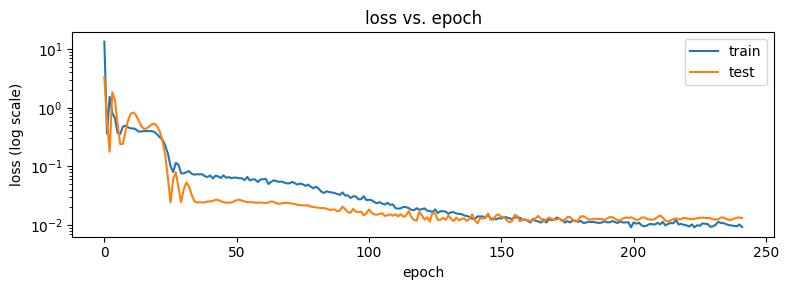

In [5]:
import os
import time
import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def training(model, dl_train, dl_test, model_path, num_epochs, device):
    torch.manual_seed(seed=42)
    model = model.to(device)
    loss_fn = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
        mode='min', factor=0.9, patience=5)
    early_stopping = EarlyStopping(patience=100, min_delta=1e-4)

    history = {'train_loss': [], 'test_loss': []}
    best_test_loss = float('inf')
    for _ in range(num_epochs):
        train_loss = train_step(model=model, dl_train=dl_train,
            loss_fn=loss_fn, optimizer=optimizer, device=device)
        history['train_loss'].append(train_loss)

        test_loss = test_step(model=model, dl_test=dl_test,
            loss_fn=loss_fn, device=device)
        history['test_loss'].append(test_loss)

        scheduler.step(test_loss)

        if test_loss < best_test_loss:
            best_test_loss = test_loss
            torch.save(obj=model.state_dict(), f=model_path)

        early_stopping(loss=test_loss)
        if early_stopping.early_stop:
            break
    return history

torch.manual_seed(seed=42)
model = TransformerForecast()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

os.makedirs('models', exist_ok=True)
model_path = 'models/best_model.pth'

start_time = time.time()
history = training(model=model, dl_train=dl_train, dl_test=dl_test,
    model_path=model_path, num_epochs=1000, device=device)
print("Training duration: %.2fs"%(time.time() - start_time))

def plot_history(history):
    df_history = pd.DataFrame(history)
    df_history.index.name = 'epoch'
    df_history.reset_index(inplace=True)

    plt.figure(figsize=(8, 3))
    sns.lineplot(data=df_history, x='epoch', y='train_loss', label='train')
    sns.lineplot(data=df_history, x='epoch', y='test_loss', label='test')
    plt.yscale('log')
    plt.legend(loc='best')
    plt.title(label="loss vs. epoch")
    plt.xlabel(xlabel='epoch')
    plt.ylabel(ylabel='loss (log scale)')
    plt.tight_layout()
    plt.show()

plot_history(history=history)

### Inference

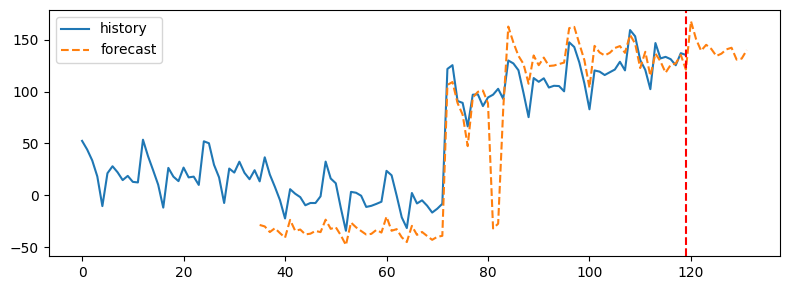

In [20]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns

torch.manual_seed(seed=42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TransformerForecast().to(device)
model.load_state_dict(torch.load(f=model_path, weights_only=True))

ts_scaled = scaler.transform(X=ts_history.reshape(-1, 1)).flatten()
len_idx = len(ts_scaled) - src_len  + 1
idx = np.arange(stop=len_idx).reshape(-1, 1) + np.arange(stop=src_len)

data = {}
data['src'] = torch.tensor(data=ts_scaled[idx], dtype=torch.float32)\
    .unsqueeze(dim=-1).to(device)
data['src_idx'] = torch.tensor(data=idx, dtype=torch.long)
data['src_month'] = (data['src_idx'] % 12).long()
data['src_month'].shape

# idx = np.arange(stop=len_idx).reshape(-1, 1) + np.arange(start=src_len,
#     stop=src_len+tgt_len) - 1
# tgt_in = torch.tensor(data=ts_scaled[idx-1], dtype=torch.float32)\
#     .unsqueeze(dim=-1).to(device)

model.eval()
with torch.no_grad():
    pred = model.infer(data=data, tgt_len=tgt_len)
ts_pred = pred[:, -1:].squeeze()
ts_pred = scaler.inverse_transform(X=ts_pred.reshape(-1, 1)).flatten()
time_pred = np.arange(start=35, stop=time_history[-1]+13, dtype=np.float32)

# time_pred = time_history[(src_len + tgt_len):] + np.arange(tgt_len)

# steps = 60
# time_future = np.arange(start=len(ts_history), stop=len(ts_history)+steps, dtype=np.float32)
# ts_future = forecast(model=model, ts=ts_history, src_len=src_len, steps=steps)

plt.figure(figsize=(8, 3))
sns.lineplot(x=time_history, y=ts_history, label='history')
sns.lineplot(x=time_pred, y=ts_pred, label='forecast', linestyle='--')
plt.axvline(x=time_history[-1], color='red', linestyle='--')
plt.legend(loc='best')
plt.tight_layout()
plt.show()